In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2023-01-20 22:14:13.279520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64

    # X = layers.LocallyConnected2D(32, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

    # X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

    OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
    OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

    OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)

    return model

In [6]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [7]:
# from importlib import reload
# reload(ck)

In [8]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [9]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy")+\
                            glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*pos*.npy")+\
                            glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/TRAIN*pos*.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*neg_neg_neg*.npy")+\
                            glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/VALID*neg_neg_neg*.npy"))

filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*pos*.npy")+\
                            glob("/glade/campaign/cisl/aiml/ksha/NCAR_batch_v3/VALID*pos*.npy"))

print('neg:{} vs pos:{}'.format(len(filename_neg_train), len(filename_pos_train)))

neg:12889243 vs pos:35801


In [10]:
filename_valid = filename_neg_valid[::600] + filename_pos_valid[::50]

In [11]:
len(filename_valid)

10149

In [12]:
#filename_valid = filename_neg_valid[::600] + filename_pos_valid[::5]
#filename_valid = filename_neg_valid[::200] + filename_pos_valid[::50]
filename_valid = filename_neg_valid[::600] + filename_pos_valid[::50]
print(len(filename_valid))

L_valid = len(filename_valid)

VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

10149


**ConvNext**

In [13]:
#tf.config.list_physical_devices('GPU')

In [18]:
training_rounds = 20

# seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
#          2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]
seeds = [473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]

min_del = 0
max_tol = 1000 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE0_15p_full'
model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = 0.05261518681620835 #1.1 #0.02882396175236131 #0.021237620777840503 #0.05669766786174394 #0.08634155630837792
print("Initial record: {}".format(record))

count = 0


for r in range(training_rounds):
    
    tol = 0 - count - r
    
    #flag_count_change = True
    
    model = create_model(input_shape=(64, 64, 15))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=1e-4))
    
    W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base/')
    model.set_weights(W_old)
    
    set_seeds(seeds[r+1])
    print('Training round {}'.format(r))
    
    for i in range(epochs):
    
        #backend.set_value(model.optimizer.learning_rate, learning_rate[i])
        
        #print('epoch = {}'.format(i))
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            
            N_pos = 20
            N_neg = batch_size - N_pos
            
            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)
        
            file_pick_neg = []
            for ind_temp in ind_neg[:N_neg]:
                file_pick_neg.append(filename_neg_train[ind_temp])

            file_pick_pos = []
            for ind_temp in ind_pos[:N_pos]:
                file_pick_pos.append(filename_pos_train[ind_temp])
        
            file_pick = file_pick_neg + file_pick_pos
            
            if len(file_pick) != batch_size:
                sregwet
        
            for k in range(batch_size):
                data = np.load(file_pick[k])
                
                for l, c in enumerate(ind_pick_from_batch):
                    temp = data[..., c] 
                    X_batch_64[k, ..., l] = temp
                    
                if 'pos' in file_pick[k]:
                    Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
                elif 'neg_neg_neg' in file_pick[k]:
                    Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
                else:
                    werhgaer
                    
            ind_ = du.shuffle_ind(batch_size)
            X_batch_64 = X_batch_64[ind_, ...]
            Y_batch = Y_batch[ind_, :]
            
            # train on batch
            model.train_on_batch(X_batch_64, Y_batch);
            
        # epoch end operations
        Y_pred = model.predict([VALID_input_64])
        # Y_pred[Y_pred<0] = 0
        # Y_pred[Y_pred>1] = 1
        
        Y_pred = 1/(1 + np.exp(-Y_pred))
        
        record_temp = verif_metric(VALID_target, Y_pred)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del) and np.max(Y_pred)>0.6:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp >= 2.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    if tol == 1 and i > count:
                        #flag_count_change = False
                        count = i
                        print(count)
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.05261518681620835
Training round 0
0.04281114936935518
Validation loss improved from 0.05261518681620835 to 0.04281114936935518
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full


2023-01-20 22:41:44.483546: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full/assets
--- 403.35063791275024 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03756649662528126
Validation loss improved from 0.04281114936935518 to 0.03756649662528126
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full/assets
--- 543.6231918334961 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04473795813445146
Validation loss 0.04473795813445146 NOT improved
2
0.040058895796183665
Validation loss 0.040058895796183665 NOT improved
0.04089006560479242
Validation loss 0.04089006560479242 NOT improved
0.04145416408180738
Validation loss 0.04145416408180738 NOT improved
0.04748943069538691
Validation loss 0.04748943069538691 NOT improved
0.03861435537141456
Validation loss 0.03861435537141456 NOT improved
0.05022395037242889
Validation loss 0.05022395037242889 NOT improved
0.03975157475795382
Validation loss 0.03975157475795382 NOT improved
0.04629020876644182
Validation loss 0.04629020876644182 NOT improved
0.03929260736765346
Validation loss 0.03929260736765346 NOT improved
0.04023859863729881
Validation loss 0.04023859863729881 NOT improved
0.04385144680272001
Validation loss 0.04385144680272001 NOT improved
0.045228791608161574
Validation loss 0.045228791608161574 NOT improved
0.047736015503356266
Validation loss 0.047736015503356266 NOT improved
0.044316564011766896
Valid

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.059048119708619985
Validation loss 0.059048119708619985 NOT improved
27
0.041324982211077506
Validation loss 0.041324982211077506 NOT improved
0.03683736663905024
Validation loss 0.03683736663905024 NOT improved
0.03949789915267097
Validation loss 0.03949789915267097 NOT improved
0.04768322378940311
Validation loss 0.04768322378940311 NOT improved
0.042191601457422276
Validation loss 0.042191601457422276 NOT improved
0.039367555933744774
Validation loss 0.039367555933744774 NOT improved
0.03951927558628424
Validation loss 0.03951927558628424 NOT improved
0.03662194486523238
Validation loss 0.03662194486523238 NOT improved
0.040406822563357106
Validation loss 0.040406822563357106 NOT improved
0.03948193533022091
Validation loss 0.03948193533022091 NOT improved
0.03502509269453094
Validation loss improved from 0.03644098476929477 to 0.03502509269453094
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0393316704987073
Validation loss 0.0393316704987073 NOT improved
39
0.04711757602381917
Validation loss 0.04711757602381917 NOT improved
0.04144576221479007
Validation loss 0.04144576221479007 NOT improved
0.039327792870235974
Validation loss 0.039327792870235974 NOT improved
0.03844081930088315
Validation loss 0.03844081930088315 NOT improved
0.034211465880337674
Validation loss improved from 0.03502509269453094 to 0.034211465880337674
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full/assets
--- 520.8445346355438 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03906962706310618
Validation loss 0.03906962706310618 NOT improved
45
0.03582237932220545
Validation loss 0.03582237932220545 NOT improved
0.03870702686457045
Validation loss 0.03870702686457045 NOT improved
0.042270691492195644
Validation loss 0.042270691492195644 NOT improved
0.04052333477010427
Validation loss 0.04052333477010427 NOT improved
0.04274286409346085
Validation loss 0.04274286409346085 NOT improved
0.042288972720300085
Validation loss 0.042288972720300085 NOT improved
0.037194094840023964
Validation loss 0.037194094840023964 NOT improved
0.0444880458507545
Validation loss 0.0444880458507545 NOT improved
0.035709243451621776
Validation loss 0.035709243451621776 NOT improved
0.03377452945971865
Validation loss improved from 0.034211465880337674 to 0.03377452945971865
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_full/assets
--- 530.9159474372864 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04039365433721299
Validation loss 0.04039365433721299 NOT improved
56
0.03385253899176745
Validation loss 0.03385253899176745 NOT improved
0.04225326061299054
Validation loss 0.04225326061299054 NOT improved
0.04311602967397943
Validation loss 0.04311602967397943 NOT improved
0.04467049997730505
Validation loss 0.04467049997730505 NOT improved
0.041031784235894105
Validation loss 0.041031784235894105 NOT improved
0.03936022804878951
Validation loss 0.03936022804878951 NOT improved
0.041834041256998834
Validation loss 0.041834041256998834 NOT improved
0.03691884621896565
Validation loss 0.03691884621896565 NOT improved
0.03815798850459914
Validation loss 0.03815798850459914 NOT improved
0.03544595001398382
Validation loss 0.03544595001398382 NOT improved
0.04103757678594585
Validation loss 0.04103757678594585 NOT improved
0.03564964304494332
Validation loss 0.03564964304494332 NOT improved
0.04064184585386649
Validation loss 0.04064184585386649 NOT improved
0.0480205587944581
Validati


KeyboardInterrupt



In [ ]:
filename_test = filename_neg_test[::200] + filename_pos_test

In [ ]:
L_test = len(filename_test)
L_var = L_vars

TEST_input_64 = np.empty((L_test, 64, 64, L_var))
TEST_target = np.ones(L_test)

for i, name in enumerate(filename_test):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

In [19]:
model = create_model(input_shape=(64, 64, 15))

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0))

#W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base/')
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_full')
model.set_weights(W_old)

In [20]:
Y_pred = model.predict([VALID_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(VALID_target, Y_pred)

0.03377452945971865


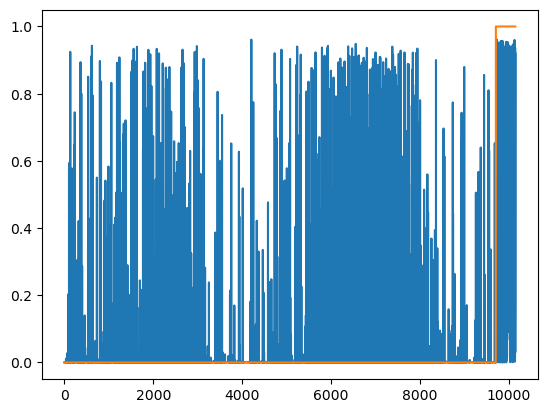

In [22]:
plt.plot(Y_pred)
plt.plot(VALID_target)

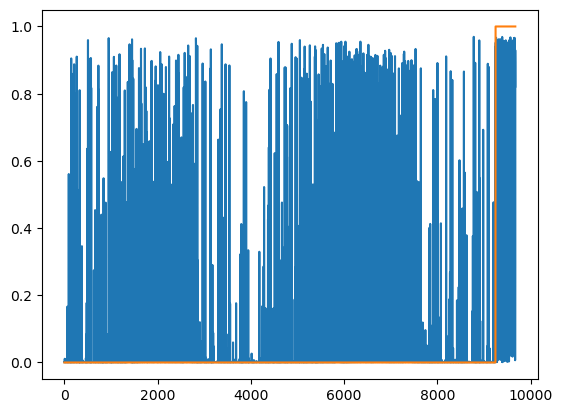

In [20]:
plt.plot(Y_pred)
plt.plot(VALID_target)

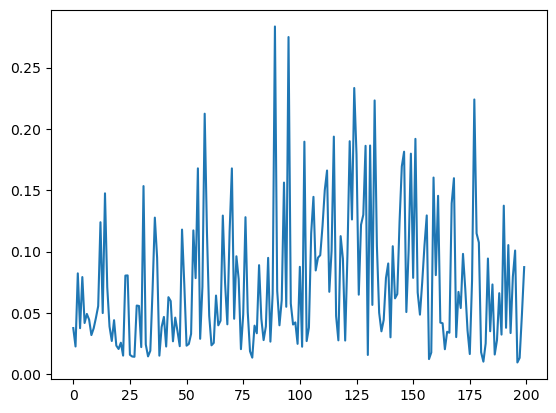

In [45]:
plt.plot(Y_pred[2000:2200])

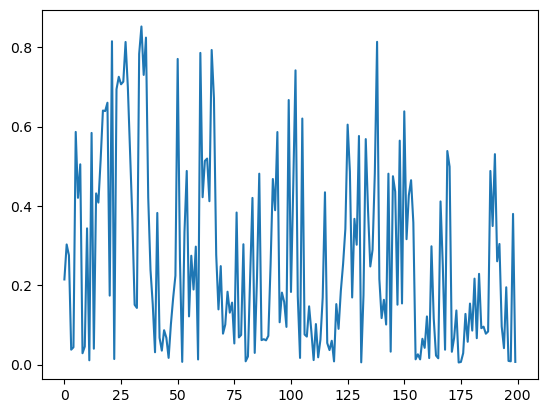

In [41]:
plt.plot(Y_pred[-200:])

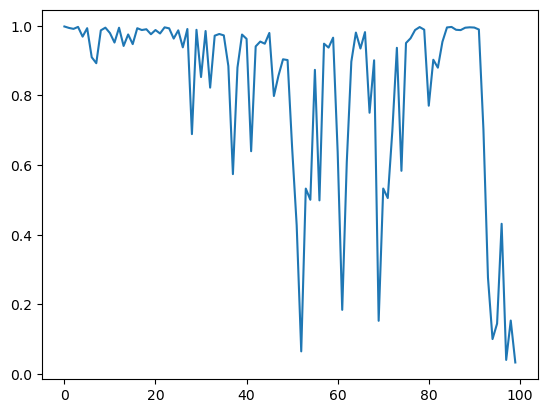

In [71]:
plt.plot(Y_pred[-100:])

In [31]:
Y_pred = model.predict([TESTv4_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(TESTv4_target, Y_pred)

0.10501852837890428


In [32]:
record_temp

0.10501852837890428